In [1]:
# https://github.com/opaliss/Parameter_Estimation_Solar_Wind/tree/main

In [1]:
from urllib.request import urlretrieve

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize
from sunpy.map import Map
from sunpy.coordinates import frames
from sunpy.coordinates.sun import carrington_rotation_time
from sunkit_magex import pfss

from hapiclient import hapi, hapitime2datetime
from hapiplot import hapiplot

In [2]:
CR = 2053
start_time = carrington_rotation_time(CR)
end_time   = carrington_rotation_time(CR + 1)
print("start date:", start_time)
print("end date:  ", end_time)

start date: 2007-02-04 20:04:57.248
end date:   2007-03-04 04:09:43.355


## ACE

hapi(): Running hapi.py version 0.2.6
hapi(): file directory = /tmp/hapi-data/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading /tmp/hapi-data/cdaweb.gsfc.nasa.gov_hapi
hapi(): Writing AC_H2_SWE___.json 
hapi(): Writing AC_H2_SWE___.pkl 
hapi(): Reading https://cdaweb.gsfc.nasa.gov/hapi/capabilities
hapi(): Writing https://cdaweb.gsfc.nasa.gov/hapi/data?id=AC_H2_SWE&parameters=V_GSE,SC_pos_GSE&time.min=2007-02-04T20:04:57Z&time.max=2007-03-04T04:09:43Z&format=binary to AC_H2_SWE_V_GSE,SC_pos_GSE_20070204T200457_20070304T040943.bin
hapi(): Reading and parsing AC_H2_SWE_V_GSE,SC_pos_GSE_20070204T200457_20070304T040943.bin
hapi(): Writing /tmp/hapi-data/cdaweb.gsfc.nasa.gov_hapi/AC_H2_SWE_V_GSE,SC_pos_GSE_20070204T200457_20070304T040943.pkl
hapi(): Writing /tmp/hapi-data/cdaweb.gsfc.nasa.gov_hapi/AC_H2_SWE_V_GSE,SC_pos_GSE_20070204T200457_20070304T040943.npy


{'HAPI': '2.0',
 'resourceURL': 'https://cdaweb.gsfc.nasa.gov/misc/NotesA.html#AC_H2_SWE',
 'contact': 'D. J. McComas @ SWRI',
 'parameters': [{'name': 'Time',
   'length': 24,
   'units': 'UTC',
   'type': 'isotime',
   'fill': None},
  {'size': [3],
   'name': 'V_GSE',
   'description': 'Solar Wind Velocity in GSE coord., 3 components',
   'units': 'km/s',
   'type': 'double',
   'fill': '-1.0E31'},
  {'size': [3],
   'name': 'SC_pos_GSE',
   'description': 'ACE s/c position, 3 comp. in GSE coord.',
   'units': 'km',
   'type': 'double',
   'fill': '-1.0E31'}],
 'startDate': '1998-02-04T00:00:00Z',
 'stopDate': '2024-07-09T23:00:00Z',
 'status': {'code': 1200, 'message': 'OK'},
 'x_server': 'https://cdaweb.gsfc.nasa.gov/hapi',
 'x_dataset': 'AC_H2_SWE',
 'x_parameters': 'V_GSE,SC_pos_GSE',
 'x_time.min': '2007-02-04T20:04:57Z',
 'x_time.max': '2007-03-04T04:09:43Z',
 'x_requestDate': '2025-11-19T16:55:48',
 'x_cacheDir': '/tmp/hapi-data/cdaweb.gsfc.nasa.gov_hapi',
 'x_downloadTime': 

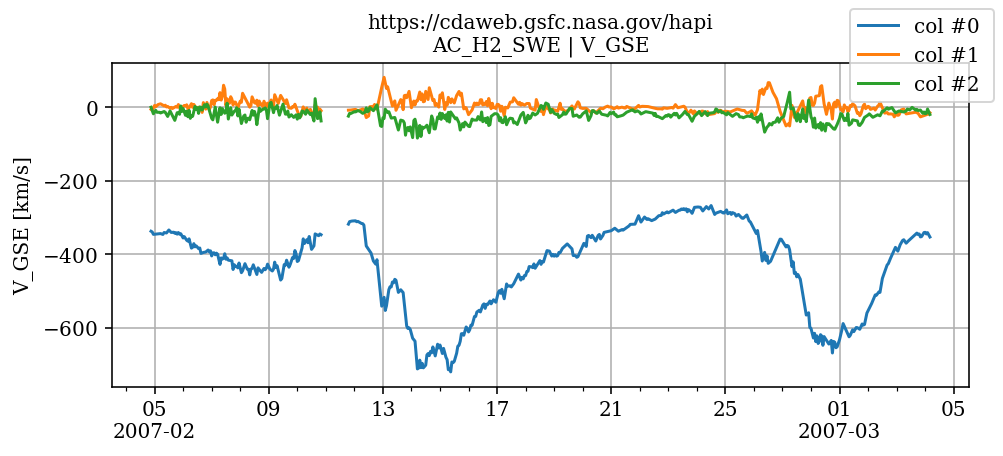

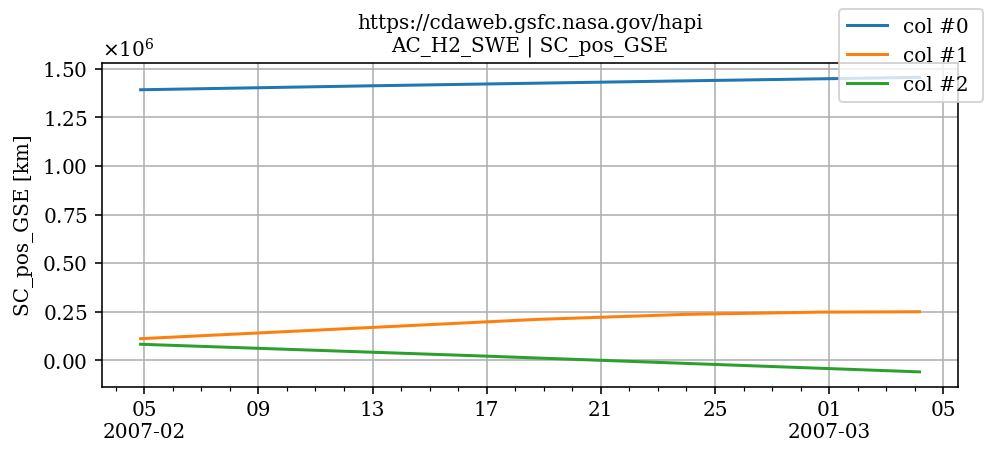

In [3]:
server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'AC_H2_SWE'
start      = '2007-02-04T20:04:57'
stop       = '2007-03-04T04:09:43'
parameters = 'V_GSE,SC_pos_GSE'
opts       = {'logging': True, 'usecache': False}

data, meta = hapi(server, dataset, parameters, start, stop, **opts)
display(meta)
hapiplot(data, meta);

In [ ]:
# get position of ACE position and measured velocity in Geocentric Solar Ecliptic (GSE) coordinates.
# this system has its X axis towards the Sun and its Z axis perpendicular to the plane of the Earth's orbit
# around the Sun (positive North).
# define as a astropy skycoord object: https://docs.astropy.org/en/stable/coordinates/velocities.html
GSE_COORDS = SkyCoord(
    x=data['SC_pos_GSE'][:,0]*u.km,
    y=data['SC_pos_GSE'][:,1]*u.km,
    z=data['SC_pos_GSE'][:,2]*u.km,
    v_x=data['V_GSE'][:,0]*u.km/u.s,
    v_y=data['V_GSE'][:,1]*u.km/u.s,
    v_z=data['V_GSE'][:,2]*u.km/u.s,
    representation_type='cartesian',
    obstime=hapitime2datetime(data['Time']),
    frame=frames.GeocentricSolarEcliptic
)
# convert to Heliographic Carrington Coordinate system.
# the origin is the center of the Sun. The Z-axis (+90 degrees latitude) is aligned with the Sun’s north pole.
# the X-axis and Y-axis rotate with a period of 25.38 days.
HG_COORDS = GSE_COORDS.transform_to(frames.HeliographicCarrington(observer='sun'))
# location in spherical coordinates (longitude, latitude, radial distance).
ACE_time = hapitime2datetime(data['Time'])
ACE_longitude = HG_COORDS.lon.to(u.deg)
ACE_latitude = HG_COORDS.lat.to(u.deg)
ACE_r = HG_COORDS.radius.to(u.km)
ACE_vr = np.abs(data['V_GSE'][:, 0])  # radial velocity component

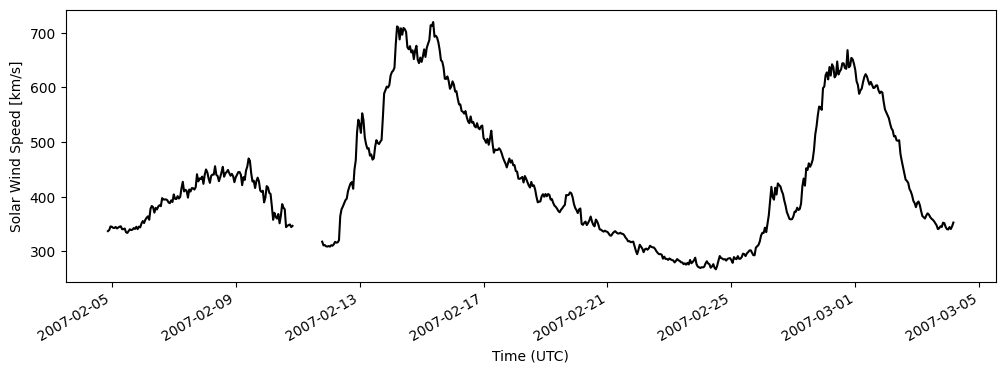

In [5]:
plt.figure(figsize=(12,4))
plt.plot(ACE_time, ACE_vr, c='k')
plt.gcf().autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Solar Wind Speed [km/s]')
plt.show()

## GONG

In [6]:
# https://magmap.nso.edu/

In [8]:
urlretrieve(
    'https://magmap.nso.edu/QR/nqs/200702/mrnqs070218/mrnqs070218t1214c2053_000.fits.gz', 
    'mrnqs070218t1214c2053_000.fits.gz'
);

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


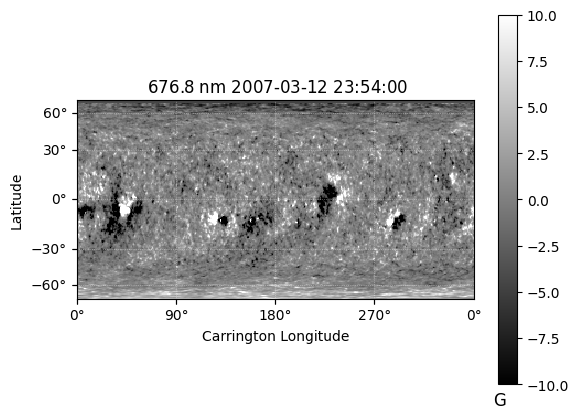

In [9]:
gong_map = Map('mrnqs070218t1214c2053_000.fits.gz')
gong_map.peek(norm=ImageNormalize(vmin=-10, vmax=10))

## PFSS

In [10]:
gong_map.data.shape

(180, 360)

In [11]:
nr = 70    # number of cells in the radial direction
rss = 2.5  # radius of the source surface in R_sun
pfss_in = pfss.Input(gong_map, nr, rss)
pfss_out = pfss.pfss(pfss_in)

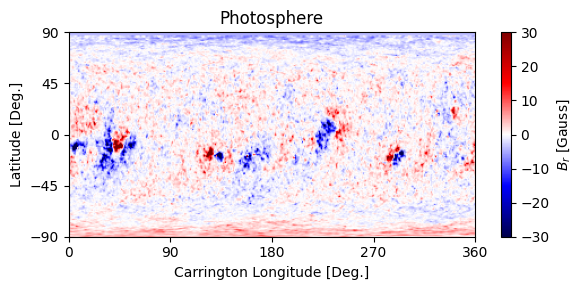

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.imshow(gong_map.data, extent=[0,360,-90, 90], origin="lower", aspect="auto", cmap="seismic", vmin=-30, vmax=30)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_yticks([-90, -45, 0, 45, 90])
cbar = fig.colorbar(pos, ax=ax, orientation="vertical")
cbar.ax.set_ylabel(r'$B_{r}$ [Gauss]', rotation=90)
ax.set_xlim(0, 360)
ax.set_xlabel("Carrington Longitude [Deg.]")
ax.set_ylabel("Latitude [Deg.]")
ax.set_title("Photosphere")
plt.tight_layout()
plt.show()

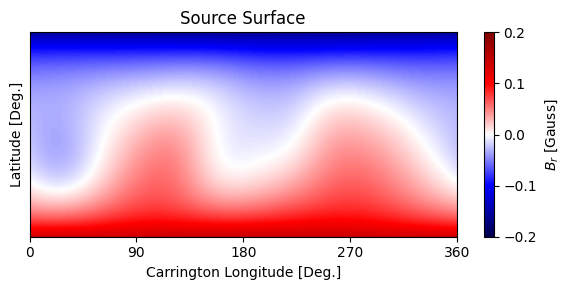

In [13]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.imshow(pfss_out.source_surface_br.data, extent=[0,360,-90, 90], origin="lower", aspect="auto", cmap="seismic", vmin=-0.2, vmax=0.2)
cbar = fig.colorbar(pos, ax=ax, orientation="vertical")
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_yticks([])
cbar.ax.set_ylabel(r'$B_{r}$ [Gauss]', rotation=90)
ax.set_xlabel("Carrington Longitude [Deg.]")
ax.set_ylabel("Latitude [Deg.]")
ax.set_title("Source Surface")
plt.tight_layout()
plt.show()

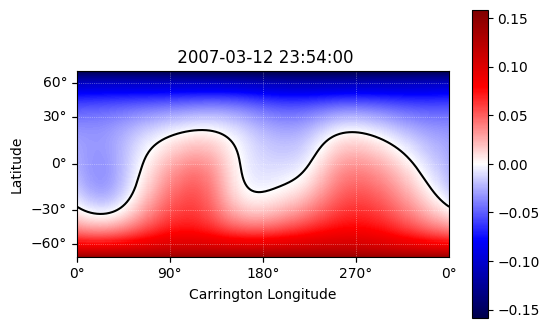

In [14]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection=pfss_out.source_surface_br)
im = pfss_out.source_surface_br.plot(axes=ax, cmap="seismic")
ax.plot_coord(pfss_out.source_surface_pils[0], color='k')
fig.colorbar(im, ax=ax)
plt.show()

In [15]:
tracer = pfss.tracing.PerformanceTracer()
r = 1.2 * const.R_sun
lat = np.linspace(-np.pi / 2, np.pi / 2, 15)
lon = np.linspace(0, 2 * np.pi, 15)
lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel() * u.rad, lon.ravel() * u.rad

seeds = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)
field_lines = tracer.trace(seeds, pfss_out)

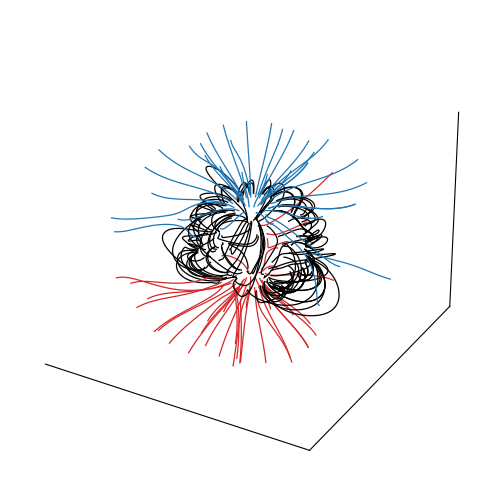

In [16]:
fig = plt.figure(constrained_layout=True, figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

for field_line in field_lines:
    color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(field_line.polarity)
    coords = field_line.coords
    coords.representation_type = 'cartesian'
    ax.plot(coords.x / const.R_sun,
            coords.y / const.R_sun,
            coords.z / const.R_sun,
            color=color, linewidth=0.9)
    
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
# Bonus: To get rid of the grid as well:
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.tight_layout()
plt.show()

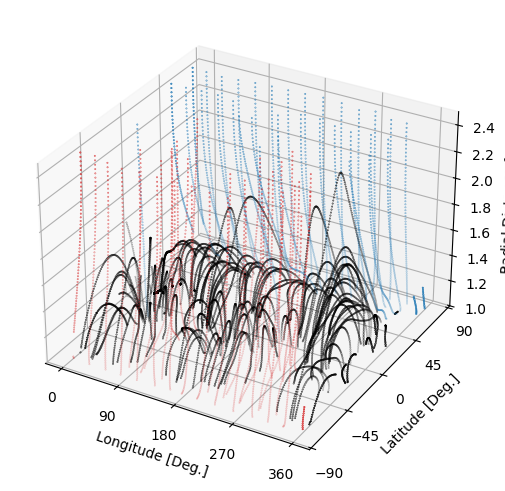

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

for field_line in field_lines:
    color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(field_line.polarity)
    coords = field_line.coords
    coords.representation_type = 'spherical'
    ax.scatter(
            coords.lon.value,
            coords.lat.value,
            coords.radius / const.R_sun,
            color=color, s=0.1)

ax.set_zlim(1, 2.5)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_yticks([-90, -45, 0, 45, 90])
ax.set_xlabel("Longitude [Deg.]")
ax.set_ylabel("Latitude [Deg.]")
ax.set_zlabel(r"Radial Distance [$R_{S}$]")
plt.tight_layout()
plt.show()

## Magnetic Expansion Factor

In [18]:
# trace the magnetic field lines for the ACE projection to obtain the expansion factor
tracer = pfss.tracing.PerformanceTracer()
seeds = SkyCoord(ACE_longitude.to(u.rad), ACE_latitude.to(u.rad), 2.5*u.solRad, frame=pfss_out.coordinate_frame)
field_lines_fp = tracer.trace(seeds, pfss_out)
fp_ace_traj = field_lines_fp.expansion_factors

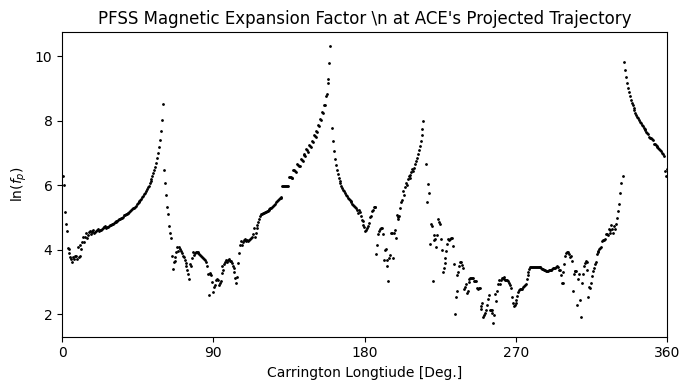

In [22]:
fig, ax = plt.subplots(figsize=(7,4))
_ = ax.scatter(ACE_longitude, np.log(fp_ace_traj), s=1, c="k")
_ = ax.set_xticks([0, 90, 180, 270, 360])
_ = ax.set_xlim(0, 360)
_ = ax.set_xlabel("Carrington Longtiude [Deg.]")
_ = ax.set_title(r"PFSS Magnetic Expansion Factor \n at ACE's Projected Trajectory")
_ = ax.set_ylabel(r"$\ln(f_{p})$")
plt.tight_layout()
plt.show()

## Coronal Hole Mapping

In [23]:
def pfss2flines(pfsspy_out, nth=180, nph=360, trace_from_SS=False, max_steps=1000, r_ss=2.5):
    """Field line tracing from photosphere or source surface.

    :param pfsspy_out: pfsspy output object
    :param nth: number of tracing grid points in latitude
    :param nph: number of tracing grid points in longitude
    :param trace_from_SS: if False : start trace from photosphere, if True, start tracing from source surface
    :param max_steps: max steps tracer should take before giving up
    :return: trace of each field line back to photosphere or out to solar surface
    """
    lons, lats = np.meshgrid(np.linspace(0, 360, nph), np.linspace(-90, 90, nth))
    if not trace_from_SS:
        # trace up from photosphere
        alt = 1 * u.R_sun
    else:
        # trace down from solar surface
        alt = r_ss * u.R_sun
    # get all tuples of the coordinates.
    alt = [alt] * len(lons.ravel())
    # create an astropy seed in HG coordinates.
    seeds = SkyCoord(lons.ravel() * u.deg,
                                         lats.ravel() * u.deg,
                                         alt,
                                         frame=pfsspy_out.coordinate_frame)
    # trace all field lines.
    field_lines = pfsspy_out.trace(pfss.tracing.PerformanceTracer(max_steps=max_steps), seeds)
    if not trace_from_SS:
        return field_lines.polarities.reshape([nth, nph])
    else:
        return field_lines.expansion_factors.reshape([nth, nph])

In [24]:
topologies = pfss2flines(pfss_out)
expansion_factor = pfss2flines(pfss_out, trace_from_SS=True)

In [25]:
lons = np.linspace(0,360, 360)
lats = np.linspace(-90, 90, 180-2)

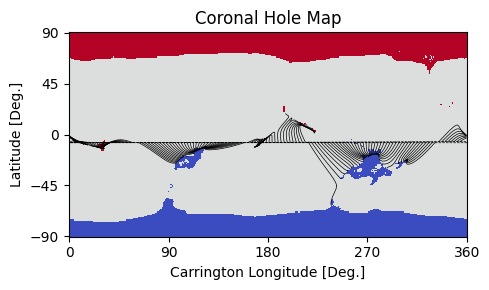

In [26]:
fig,ax = plt.subplots(figsize=(5, 3))
pos = ax.pcolormesh(lons, lats, topologies[1:-1, :], cmap='coolwarm_r')
ax.plot(ACE_longitude.to(u.deg), ACE_latitude.to(u.deg), c="black", ls="--", linewidth=0.5)

_ = ax.set_xlabel("Carrington Longitude [Deg.]")
_ = ax.set_ylabel("Latitude [Deg.]")
_ = ax.set_xticks(np.linspace(0, 360, 5))
_ = ax.set_yticks(np.linspace(-90, 90, 5))
_ = ax.set_title(r"Coronal Hole Map")

for ii in range(7, len(ACE_longitude.to(u.rad))):
    if ii % 5 == 0:
        field_line = field_lines_fp[ii]
        coords = field_line.coords
        color= "black"
        if len(coords.lon) > 1:
            if np.max(np.abs(coords.lon[1:].value - coords.lon[:-1].value)) < 200:
                ax.plot(coords.lon, coords.lat, c=color, linewidth=0.5)
            else:
                index = np.argmax(np.abs(coords.lon[1:].value - coords.lon[:-1].value))
                ax.plot(coords.lon[:index], coords.lat[:index], c=color, linewidth=0.5)
                ax.plot(coords.lon[index+1:], coords.lat[index+1:], c=color, linewidth=0.5)

plt.tight_layout()
plt.show()

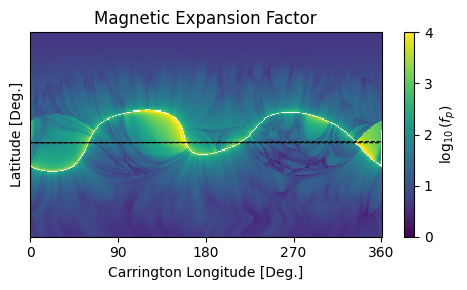

In [27]:
fig,ax = plt.subplots(figsize=(5, 3))

pos = ax.pcolormesh(lons, lats, np.log10(expansion_factor)[1:-1, :], vmin=0, vmax=4)
cbar = fig.colorbar(pos, ax=ax, orientation="vertical")
cbar.ax.set_ylabel(r'$\log_{10}(f_{p})$', rotation=90)
ax.plot(ACE_longitude.to(u.deg), ACE_latitude.to(u.deg), c="black", ls="--", linewidth=0.8)

_ = ax.set_xlabel("Carrington Longitude [Deg.]")
_ = ax.set_ylabel("Latitude [Deg.]")
_ = ax.set_xticks(np.linspace(0,360,5))
_ = ax.set_yticks([])
_ = ax.set_title(r"Magnetic Expansion Factor")

plt.tight_layout()
plt.show()

## Great-circle angular distance from the nearest coronal hole boundary at the photosphere

$d = \arccos\left[\cos(\theta_{1}) \cos(\theta_{2}) \cos(\phi_{1}- \phi_{2}) + \sin(\theta_{1}) \sin(\theta_{2})\right]$

In [28]:
def distance_to_coronal_hole_boundary(topologies, field_lines_fp):
    """compute the distance to the nearest coronal hole boundary.
    **in practice: compute the distance from the footprint to the nearest closed footprint.

    :param topologies: coronal hole map. array of size [n_theta~180, n_phi~360]
    :param field_lines_fp: field line tracing for ace simulation_output.
    :return: distance to coronal hole for each solar source field line footpoint on the photosphere.
    """
    # initialize the distance to coronal hole vector.
    d = np.zeros(len(field_lines_fp))
    # longitude and latitude uniform grids in radians.
    latitude = np.linspace(-np.pi / 2, np.pi / 2, np.shape(topologies)[0])
    longitude = np.linspace(0, 2 * np.pi, np.shape(topologies)[1])
    # location of closed magnetic field lines (footprint).
    latitude = latitude[np.where(topologies == 0)[0]]
    longitude = longitude[np.where(topologies == 0)[1]]

    for ii in range(len(d)):
        try:
            phi2 = field_lines_fp[ii].solar_footpoint.lon.to(u.rad).value
            theta2 = field_lines_fp[ii].solar_footpoint.lat.to(u.rad).value
            d_full_sun = np.arccos(np.cos(latitude) * np.cos(theta2) * (np.sin(phi2) * np.sin(longitude) +
                                                                        np.cos(longitude) * np.cos(phi2)) + np.sin(
                latitude) * np.sin(theta2))
            d[ii] = np.min(d_full_sun)
        except:
            d[ii] = 0
    return d

In [29]:
d_ace_traj = distance_to_coronal_hole_boundary(topologies, field_lines_fp)

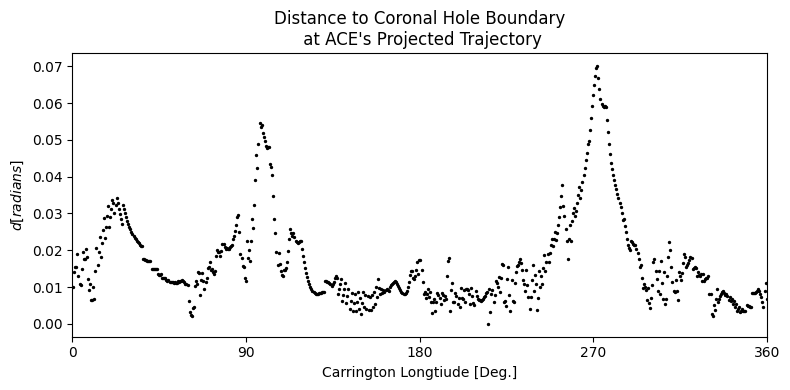

In [30]:
fig, ax = plt.subplots(figsize=(8,4))

_ = ax.scatter(ACE_longitude, d_ace_traj, s=2, c="k")
_ = ax.set_xticks([0, 90, 180, 270, 360])
_ = ax.set_xlim(0, 360)
_ = ax.set_xlabel("Carrington Longtiude [Deg.]")
_ = ax.set_title("Distance to Coronal Hole Boundary\n at ACE's Projected Trajectory")
_ = ax.set_ylabel("$d [radians]$")
plt.tight_layout()
plt.show()

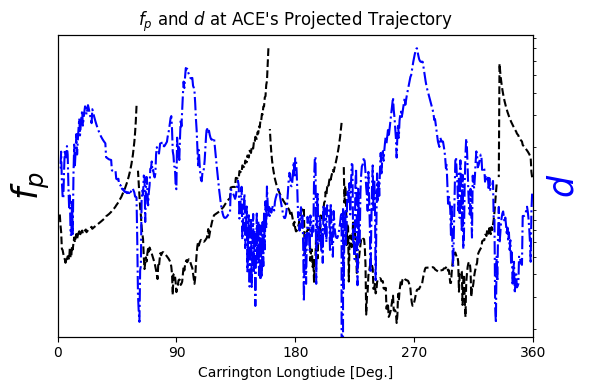

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.plot(ACE_longitude[:-3], np.log10(fp_ace_traj[:-3]), ls="--", c="k")
_ = ax.set_xticks([0, 90, 180, 270, 360])
_ = ax.set_xlim(0, 360)
_ = ax.set_yticks([])
_ = ax.set_xlabel("Carrington Longtiude [Deg.]")
_ = ax.set_title("$f_{p}$ and $d$ at ACE's Projected Trajectory")
_ = ax.set_ylabel("$f_{p}$",fontsize=25)


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
_ = ax2.plot(ACE_longitude[:-3], d_ace_traj[:-3], ls="-.", c="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_yscale("log")
ax2.set_ylabel("$d$", color="b",fontsize=25)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

## WSA

WSA is an empirical model of the ambient solar wind. The WSA model is based on the inverse relationship between the solar wind speed and the magnetic field expansion
factor $f_{p}$ and the minimum angular distance that an open field
footpoint lies from the nearest coronal hole boundary $d$, such that
\begin{equation}
    f_{p} = \left(\frac{1}{r_{\text{SS}}}\right)^2 \left|\frac{B_{r}(r_{0}, \theta_{0}, \phi_{0})}{B_{r}(r_{SS}, \theta_{1}, \phi_{1})} \right|
\end{equation}
where the indicies $0$ and $1$ refer to the longitude and latitude at the solar surface and upper boundary. These values are obtained by tracing the field lines down from $r_{SS}$ using a 4th order Runge Kutta scheme. The WSA model relation is given by 
\begin{equation}
    v_{\text{wsa}}(f_{p}, d) = v_{0} + \frac{v_{1} - v_{0}}{(1+f_{p})^{\alpha}} \left(\beta - \gamma \exp \left(-\left(\frac{d}{\omega}\right)^{\delta} \right)\right)^{\psi}
\end{equation}
The authors in [(Kumar et al. 2020)](https://www.frontiersin.org/articles/10.3389/fspas.2020.572084/full) set $v_{0} = 250 \frac{\text{km}}{\text{s}}$, $v_{1} = 900 \frac{\text{km}}{\text{s}}$, $\alpha = 1.5/9$, $\beta = 1$, $\gamma = 0.8$, $\omega = 0.03$, $\delta = 1.5$, $\psi=3$.


The authors in [(Bailey et al. 2021)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020SW002673) set $v_{0} = 250 \frac{\text{km}}{\text{s}}$, $v_{1} = 650 \frac{\text{km}}{\text{s}}$, $\alpha = 0.19$, $\beta = 1$, $\gamma = 0.8$, $\omega = 3^{\circ}$, $\delta = 1.75$, $\psi = 3$.


The authors in [(Reiss et al. 2016)](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2016SW001390) set $v_{0} = 250 \frac{\text{km}}{\text{s}}$, $v_{1} = 1125 \frac{\text{km}}{\text{s}}$, $\alpha = 0.2$, $\beta = 1$, $\gamma = 0.8$, $\omega = 2.6^{\circ}$, $\delta = 1.25$, $\psi = 2.5$.


In [32]:
# parameter from kumar et al. 2020
v0 = 250
v1 = 945
alpha = 0.16
beta = 1
gamma = 0.6
w = 0.02
delta = 1.75
psi = 3

In [33]:
v_wsa = v0 + (v1 - v0)/((1+fp_ace_traj)**alpha) * (beta - gamma* np.exp(-(d_ace_traj/w)**delta))**psi

In [34]:
def interpolate_ace_data(x, xp, fp, period):
    """return the interpolate values on new grid x of data (xp, fp)

    Parameters
    ----------
    x: array
        1d array of new grid coordinate
    xp: float
        1d array of old grid coordinate
    fp: bool
        1d array data on xp coordinate
    period: float
        periodicity

    Returns
    -------
    array
        1d array interpolated on xp
    """
    return np.interp(x=x, xp=xp[~np.isnan(fp)], fp=fp[~np.isnan(fp)], period=period)

In [35]:
p_hux = np.linspace(0, 2*np.pi, len(ACE_longitude))
r_vec = (np.linspace(2.5, np.max(ACE_r.to(u.solRad)).value, 300) * u.solRad).to(u.km).value

v_wsa_interp = interpolate_ace_data(x=p_hux, xp=ACE_longitude.to(u.rad).value, fp=v_wsa, period=2*np.pi)

In [36]:
def get_differential_rotation(theta):
    """The angular frequency of the Sun’s rotation is evaluated at a constant Carrington latitude θ, estimated by
                                 Ωrot(θ) = 2π/25.38 − 2.77π/180 cos(θ)^2

    :param theta: constant theta slice [-pi/2, pi/2] in radians.
    :return: differential rotation rate in 1/seconds.
    """
    return ((np.pi * 2 / 25.38 - 2.77 * (np.pi / 180) * (np.cos(theta) ** 2))/u.day).to(1/u.s).value


def apply_hux_f_model(initial_condition,
                      dr_vec,
                      dp_vec,
                      r0=(30 * u.solRad).to(u.km).value,
                      alpha=0.15,
                      rh=(50 * u.solRad).to(u.km).value,
                      add_v_acc=True,
                      theta=0):
    """Apply 1d upwind model to the inviscid burgers equation.
    r/phi grid. return and save all radial velocity slices.

    :param theta: constant theta slice in radians [-pi/2, pi/2]
    :param initial_condition: 1d array, initial condition (vr0). units = (km/sec).
    :param dr_vec: 1d array, mesh spacing in r. units = (km)
    :param dp_vec: 1d array, mesh spacing in p. units = (radians)
    :param alpha: float, hyper parameter for acceleration (default = 0.15).
    :param rh: float, hyper parameter for acceleration (default r=50*695700). units: (km)
    :param r0: float, initial radial location. units = (km).
    :param add_v_acc: bool, True will add acceleration boost.
    :return: velocity matrix dimensions (nr x np)
    """
    v = np.zeros((len(dr_vec) + 1, len(dp_vec) + 1))  # initialize array vr.
    v[0, :] = initial_condition

    # define omega rotation
    omega_rot = get_differential_rotation(theta=theta)

    if add_v_acc:
        v_acc = alpha * (v[0, :] * (1 - np.exp(-r0 / rh)))
        v[0, :] = v_acc + v[0, :]

    for i in range(len(dr_vec)):
        for j in range(len(dp_vec) + 1):

            if j == len(dp_vec):  # force periodicity
                v[i + 1, j] = v[i + 1, 0]

            else:
                if (omega_rot * dr_vec[i]) / (dp_vec[j] * v[i, j]) > 1:
                    print(dr_vec[i] - dp_vec[j] * v[i, j] / omega_rot)
                    print(i, j)  # courant condition

                frac1 = (v[i, j + 1] - v[i, j]) / v[i, j]
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
                v[i + 1, j] = v[i, j] + frac1 * frac2
    return v


def interp_2d_ace_hux(p_hux, r_hux, vr_hux, ACE_r, ACE_longitude):
    """ interpolate HUX results at ACE trajectory.

    :param p_hux: uniform grid in longitude. [0 -> 2pi]
    :param r_hux: uniform grid in the radial direction. [r_ss -> max(ACE_r)]
    :param vr_hux: radial velocity results. [km/s] on [r_hux, p_hux] grid.
    :param ACE_r: ACE radial trajectory in km.
    :param ACE_longitude: ACE longitude trajectory in degrees.
    :return: vr at ACE trajectory
    """
    # f = interp2d(x=p_hux, y=r_hux, z=vr_hux, kind='linear')
    
    f = RegularGridInterpolator(
        (r_hux, p_hux),     # (r, p)
        vr_hux,             # shape (len(r_hux), len(p_hux))
        method='linear',
        bounds_error=False, # 범위 밖에서 에러 대신 fill_value 반환
        fill_value=np.nan,
    )

    # initialize
    vr_ace_interp = np.zeros(len(ACE_r))
    # loop over each point
    for ii in range(len(ACE_r)):
        r_val = ACE_r.to(u.km).value[ii]        # r
        p_val = ACE_longitude.to(u.rad).value[ii]  # longitude
        # RegularGridInterpolator 는 (r, p) 순서로 포인트를 받습니다.
        vr_ace_interp[ii] = f((r_val, p_val))
        # vr_ace_interp[ii] = f(x=ACE_longitude.to(u.rad).value[ii], y=ACE_r.to(u.km).value[ii])
    return vr_ace_interp

In [37]:
vr_hux_wsa = apply_hux_f_model(initial_condition=v_wsa_interp, 
                               dr_vec=r_vec[1:] - r_vec[:-1], 
                               dp_vec=p_hux[1:] - p_hux[:-1], 
                               alpha=0.15, r0=2.5, rh=50, 
                               theta=np.mean(np.pi/2 - ACE_latitude.to(u.rad).value))

In [38]:
vr_wsa_interp = interp_2d_ace_hux(p_hux, r_vec, vr_hux_wsa, ACE_r, ACE_longitude)

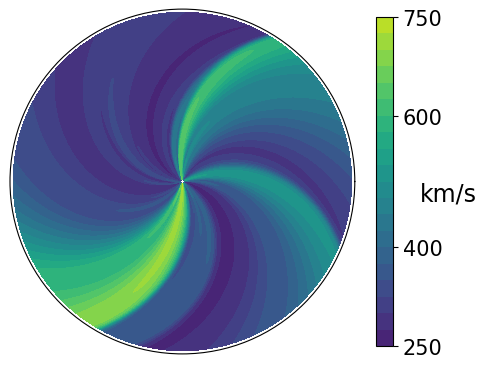

In [48]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_yticks([])
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.contourf(p_hux, (r_vec*u.km).to(u.AU).value, vr_hux_wsa, 20, vmin=200, vmax=800, shading='gouraud', cmap="viridis")

cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=360, fontsize=17)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_yticks([750, 600, 400, 250])

plt.tight_layout()
plt.show()

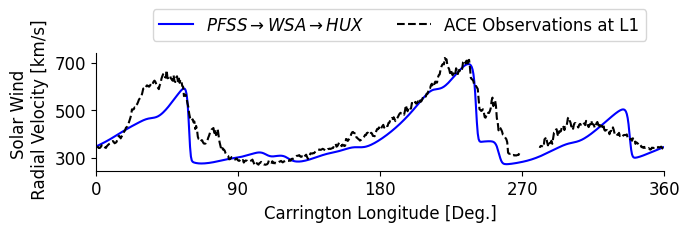

In [43]:
fig, ax = plt.subplots(figsize=(7, 2.5))
ax.plot(ACE_longitude[:-2], vr_wsa_interp[:-2], "b", label=r"$PFSS \rightarrow WSA \rightarrow HUX$")
ax.plot(ACE_longitude[:-2], ACE_vr[:-2], ls="--", c="k", label="ACE Observations at L1")
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_xticklabels([0, 90, 180, 270, 360], fontsize=12)
ax.set_yticks([300, 500, 700])
ax.set_yticklabels([300, 500, 700], fontsize=12)
ax.set_xlim(0, 360)
ax.set_xlabel("Carrington Longitude [Deg.]", fontsize=12)
ax.set_ylabel("Solar Wind \n Radial Velocity [km/s]", fontsize=12)
ax.legend(fontsize=12, loc=(0.1, 1.1), ncols=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.show()